In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import re

from getpass import getpass
from matplotlib import pyplot as plt
from pprint import pprint
from pycarta.api import create_agent
from pycarta.api.data import *
from pycarta.graph.node import Node

# Login to Carta

In [2]:
cookie = getpass("Enter CartaAuth cookie: ")
agent = create_agent(cookie, url="https://dev.carta.contextualize.us.com/api")

Enter CartaAuth cookie:  ···············································································································································································································································································································································································································································································································································································································································································································································································································································································································································································································

# Setup

## Create a simple graph

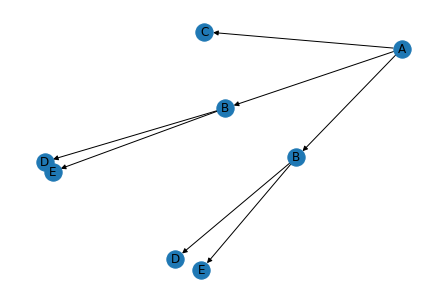

In [3]:
G = nx.DiGraph()

#         D
#     B < 
# A <     E
#     C
#
#          D
#      B <
#     /    E
#    /
# A <-- C
#    \
#     \     D'
#      B' <
#           E'
#
# A.properties = {"carta": 0.22}
# B.properties = {"Kappes": "Branden", "number": 483}
# D.properies = {"org": "UTEP"}
A = Node("A", properties=[Node.Property(name="carta", values=[0.22])])
B = Node("B", properties=[
    Node.Property(name="Kappes", values=["Branden"]),
    Node.Property(name="number", values=[483])
])
C = Node("C", properties=[Node.Property(name="call", values=["function"])])
D = Node("D", properties=[Node.Property(name="org", values=["UTEP"])])
E = Node("E", properties=[Node.Property(name="eagle", values=["bird"])])
Bp = Node("B", properties=[
    Node.Property(name="Kappes", values=["Ronel"]),
    Node.Property(name="number", values=[3243])
])
Dp = Node("D", properties=[Node.Property(name="org", values=["GT"])])
Ep = Node("E", properties=[Node.Property(name="eagle", values=["raptor"])])

G.add_edges_from([
    (A, B),
    (A, C),
    (A, Bp),
    (B, D),
    (B, E),
    (Bp, Dp),
    (Bp, Ep)
])
nx.draw_kamada_kawai(G, labels={k:k.label for k in G.nodes});

## Push graph into Carta

In [4]:
cg = post_graph(
    agent,
    "User",
    label="simple-graph",
    edges=list(G.edges)
)

## Pull graph from Carta

In [5]:
cg

{'id': '0',
 'directed': True,
 'dynamic': True,
 'nodes': [{'id': '2a8fa26e-6c79-4da9-99e6-69dc315953df',
   'label': 'E',
   'properties': [{'id': 'eagle', 'values': ['bird']}]},
  {'id': '06e05957-5394-45fa-93b1-5ba1f35f69ad',
   'label': 'C',
   'properties': [{'id': 'call', 'values': ['function']}]},
  {'id': '924f0b8d-1ae9-426a-b132-af75bcabc479',
   'label': 'D',
   'properties': [{'id': 'org', 'values': ['UTEP']}]},
  {'id': '3d835268-02a2-46fd-8bc9-340a9ba0b4a6',
   'label': 'E',
   'properties': [{'id': 'eagle', 'values': ['raptor']}]},
  {'id': 'badd0619-0646-4b01-b90c-5332c67c0fec',
   'label': 'D',
   'properties': [{'id': 'org', 'values': ['GT']}]},
  {'id': '025dbc45-005b-42b1-8a16-3be64c4b6141',
   'label': 'B',
   'properties': [{'id': 'Kappes', 'values': ['Ronel']},
    {'id': 'number', 'values': [3243]}]},
  {'id': 'f28c3a26-6d4b-4c62-a2ed-60d8ca45a390',
   'label': 'B',
   'properties': [{'id': 'Kappes', 'values': ['Branden']},
    {'id': 'number', 'values': [483]}]

## Clean up resources on Carta

In [6]:
delete_resource(agent, "User", 0)

<Response [200]>

# Prototype

## Convert Carta graph into networkx graph

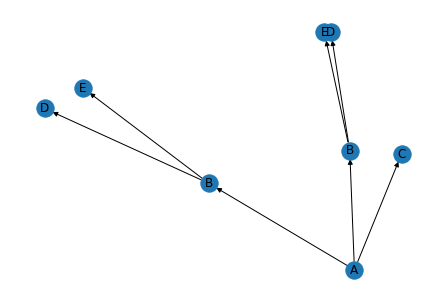

In [7]:
def to_digraph(response):
    """
    Creates a networkx DiGraph from the JSON package received from Carta.
    
    Parameters
    ----------
    response : JSON object
        JSON-formatted graph returned from Carta.
        
    Returns
    -------
    nx.DiGraph
    """
    G = nx.DiGraph()
    nodeMap = {
        n["id"]:Node(
            label=n["label"],
            id=n["id"],
            properties=[Node.Property(id=p["id"], values=p["values"]) for p in n["properties"]]
        ) for n in response["nodes"]
    }
    edges = [(nodeMap[e["from"]], nodeMap[e["to"]]) for e in response["edges"]]
    G.add_nodes_from(list(nodeMap.values()))
    G.add_edges_from(edges)
    return G

G2 = to_digraph(cg)

nx.draw_kamada_kawai(G2, labels={k:k.label for k in G2.nodes});

## Identify node equivalence

**Goal** Find equivalent subtrees in an arbitrary graph.

1. Equivalence in a leaf node: all properties are the same.
    1. Default: Same key/value pairs
    1. Optional: Values need not match (equivalence on keys only)
1. Equivalence in non-leaf node: equivalent children and all properties are the same.
    1. Same options for property equivalence as leaf node.
    
### Algorithm
1. Start with empty dict of nodes: dict\[source node, reference node\]
1. Foreach leaf node (out-degree = 0):
    1. Is this leaf node equivalent to one in the set?
        1. Yes. Continue.
        1. No. Add new node.
1. Foreach node that connects to a leaf node:
    1. Is this node equivalent to one in the set?
        1. Yes. Continue.
        1. No. Add new node; children are reference nodes from mapping.
1. Repeat the previous step until all nodes have been visited. (Depth-first traversal?)
1. Create an empty set of names.
1. Iterate through all nodes.
    1. If node name not in set, add node name to set. Continue.
    1. If node name in name set, rename node to "\[node name\]-N", where N is the first integer that makes the name unique.
        
This creates a graph where every node is a unique collection: in name, of children, and of properties.

### HyperThought-specific
For every node with properties and out-degree != 0 (Old Node):
1. Create New Node named "\[node name\] attributes" with the properties from Old Node.
1. Remove properties from Old Node.
1. Create edge from Old Node to New Node.

All nodes with properties derive from `ProcessBuilder`. All nodes without properties derive from `WorkflowBuilder`.

## TODO
Identify roots for more complex inheritance, that is, can base class--derived class relationships be identified from this graph?

In [8]:
def camel_case(s):
    return re.sub(r'([^a-zA-Z0-9])+', ' ', s).title().replace(' ', '')

for word in (
    "Hello World, this is Branden",
    "Hello World-1 Attributes"
):
    print(word, "->", camel_case(word))

Hello World, this is Branden -> HelloWorldThisIsBranden
Hello World-1 Attributes -> HelloWorld1Attributes


In [9]:
import re
from abc import ABC, abstractmethod
from functools import reduce
from itertools import count

class IrreducibleGraphBase(ABC):
    def __init__(self):
        """
        
        """
        self._node_map = dict() # dict[Node, Node]
        self._name_map = dict() # dict[Node, str]
        self._initial_graph = None
        self._irreducible_graph = None
        self._reduced_graph = None
        
    # ##### API ##### #
    
    def fit(self, graph, *, compare_labels=False, compare_values=True):
        """
        Fits a Carta graph to create a template that can be used to
        reproduce that structure.
        
        Parameters
        ----------
        graph : nx.DiGraph
            Graph retrieved from Carta
        """
        self._fit(graph, compare_labels=compare_labels, compare_values=compare_values)
        self._graph_finalize()
        return self

    def to_json(self):
        return [self._node_rep(n) for n in self._reduced_graph.nodes]
    
    # ##### implementation details ##### #
    
    @abstractmethod
    def _node_rep(self, node):
        pass
    
    @abstractmethod
    def _fit(self, graph, *, compare_labels=False, compare_values=True):
        self._initial_graph = graph
        nodes = list(graph.nodes)
        # compare unique pairs of nodes.
        _ = [
            self._compare_nodes(
                nodes[i], nodes[j], graph,
                compare_labels=compare_labels,
                compare_values=compare_values)
            for i,j in zip(*np.triu_indices(len(nodes)))
        ]
        self._irreducible_graph = nx.relabel_nodes(graph, self._node_map)
            
    def _graph_finalize(self):
#         def get_node_id(G, n):
#             # Creates a tuple of (node, child1, child2, ...)
#             # irrespective of the order of the children.
#             return (
#                 (self._node_map[n],) + 
#                 tuple(
#                     sorted(
#                         [
#                             self._node_map[n] for n in G.successors(n)
#                         ],
#                         key=lambda a: a.id
#                     )
#                 )
#             )
        def descendents(graph, node):
            return (node,) + tuple(get_descendents(graph, c) for c in graph.successors(node))
        def unique(nc):
            result = set()
            for entry in set(nc):
                children = tuple(_[0] for _ in entry[1:])
                result.add((entry[0],) + children)
                for child in children:
                    result.update(unique(child))
            return result
        # Build structure-aware graph
        G = self._initial_graph
        roots = tuple(descendents(G, n) for n in G.nodes if G.in_degree(n) == 0)
        self._minimal_structures = reduce(lambda a,b: a.union(b), roots)
#         # Maps all the nodes to their templated values
#         G = self._initial_graph
#         # map the intial graph to the nodes and their children/successors
#         keys = set(get_node_id(G, n) for n in nx.algorithms.dfs_preorder_nodes(G))
#         nmap = {k: Node(k[0].label) for k in keys}
#         self._reduced_graph = nx.relabel_nodes(G, nmap)
#         # create unique names for each node type and children
#         for node in self._reduced_graph.nodes:
#             label = node.label
#             i = count(start=1)
#             while label in self._name_map.values():
#                 label = f"{node.label}-{next(i)}"
#             self._name_map[node] = label
    
    def _name_to_typename(self, s):
        return re.sub(r'([^a-zA-Z0-9])+', ' ', s).title().replace(' ', '')

    def _compare_nodes(self, n1, n2, graph=None, *, compare_labels=False, compare_values=True):
        def prop_equal(p1, p2):
            p1 = {p.id: p.values for p in p1}
            p2 = {p.id: p.values for p in p2}
            equiv = set(p1) == set(p2)
            if equiv and compare_values:
                for k in p1:
                    equiv = (tuple(p1[k]) == tuple(p2[k]))
                    if not equiv:
                        break
            return equiv
        
        # normalize the name
        if n1 not in self._node_map:
            self._node_map[n1] = n1
        if n2 not in self._node_map:
            self._node_map[n2] = n2    
        n1 = self._node_map[n1]
        n2 = self._node_map[n2]
        # short circuit if n1 and n2 are the same
        if n1 is n2:
            return True
        # equality of properties
        equiv = prop_equal(n1.properties, n2.properties)
        if equiv and compare_labels:
            # The labels need not be the same if the structure and leaf nodes are
            # are identical.
            equiv = (n1.label == n2.label)
        if equiv:
            if graph:
                deg1 = graph.out_degree(n1)
                deg2 = graph.out_degree(n2)
                equiv = (deg1 == deg2)
                if equiv and (deg1 > 0):
                    # Not leaf nodes --> check successors
                    s1 = list(graph.successors(n1))
                    s2 = list(graph.successors(n2))
                    # A matrix of node equivalencies
                    # Each successor of one node is compared to the successors
                    # of the other node. If every successor node in A has an
                    # equivalent successor node in B. A and B can have multiple
                    # references to the same successor, but unless they have the
                    # same number of references, the equivalence matrix will
                    # have one row or one column without a matching successor.
                    nodesMatch = np.array(
                        [
                            [
                                self._compare_nodes(c1, c2, graph,
                                     compare_labels=compare_labels,
                                     compare_values=compare_values)
                                for c2 in s2
                            ]
                            for c1 in s1
                        ],
                        dtype=bool
                    )
                    equiv = (
                        np.all(np.any(nodesMatch, axis=0)) and
                        np.all(np.any(nodesMatch, axis=1))
                    )
        if equiv:
            # n1 and n2 are the same
            self._node_map[n1] = n1
            self._node_map[n2] = n1
            # remove previous mappings to n2
            for k,v in self._node_map.items():
                if v is n2:
                    self._node_map[k] = n1
        return equiv


class IrreducibleGraphHyperThought(IrreducibleGraphBase):
    def __init__(self):
        super().__init__()
        
    def _fit(
        self,
        graph,
        *,
        compare_labels=False,
        compare_values=True
    ):
        # HyperThought imposes restrictions on nodes.
        G = graph.copy()
        for node in G.nodes:
            # Workflow Nodes cannot have properties and Process Nodes
            # cannot have children, i.e. span levels. Therefore, any
            # node that has both children and properties must be split
            # into a Workflow node, with no properties, and a Process
            # node with its properties.
            if self.is_workflow(node) and (len(node.properties) > 0):
                label = f"{self._node_map[node].label} Attributes"
                attr = Node(
                    label,
                    properties=[
                        Node.Property(id=p.id, values=p.values)
                        for p in node.properties
                    ]
                )
                node.properties = []
                G.add_edge(node, attr)
        # Now that the initial graph has been modified to accommodate
        # the restriction imposed by HyperThought, continue.
        super()._fit(G, compare_labels=compare_labels, compare_values=compare_values)

    def _node_rep(self, node):
        if self.is_workflow(node):
            return self._workflow_rep(node)
        else:
            return self._process_rep(node)
            
    def is_workflow(self, node):
        for G in (self._initial_graph, self._irreducible_graph, self._reduced_graph):
            try:
                return (G.out_degree(node) > 0) or (len(node.properties) == 0)
            except (AttributeError, KeyError):
                pass
        return False
    
    def is_process(self, node):
        for G in (self._initial_graph, self._irreducible_graph, self._reduced_graph):
            try:
                return (G.out_degree(node) == 0) and (len(node.properties) > 0)
            except (AttributeError, KeyError):
                pass
        return False
    
    def _workflow_rep(self, node):
        typename = self._name_to_typename(self._name_map[node])
        rep = {
            "id": typename,
            "type": "WorkflowBuilder",
            "contains": []
        }
        for child in self._reduced_graph.successors(node):
            name = self._name_map[child]
            typename = self._name_to_typename(name)
            rep["contains"].append(
                {
                    "type": typename,
                    "name": name
                }
            )
        return rep
    
    def _process_rep(self, node):
        name = self._name_map[node]
        typename = self._name_to_typename(name)
        rep = {
            "id": typename,
            "type": "ProcessBuilder",
            "contains": []
        }
        # Properties in Carta can hold multiple values. HyperThought
        # can only handle scalar/string values. The following handles
        # this disparity.
        for prop in node.properties:
            key = prop.id
            values = prop.values or None
            if values:
                i = count(1)
                rep["contains"].append(
                    {
                        "key": key,
                        "value": values[0]
                    }
                )
                for v in values[1:]:
                    k = f"{key}-{next(i)}"
                    rep["contains"].append(
                    {
                        "key": k,
                        "value": v
                    }
                )
            else:
                rep["contains"].append(
                    {
                        "key": key
                    }
                )
        return rep

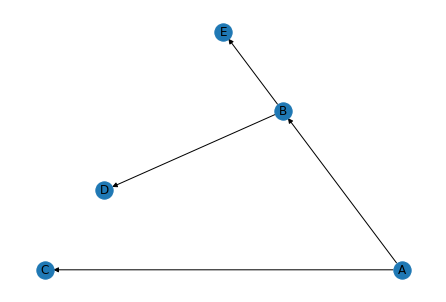

In [10]:
irred = IrreducibleGraphHyperThought().fit(G2, compare_values=False)
nx.draw_planar(irred._irreducible_graph, labels={k:k.label for k in irred._irreducible_graph.nodes})

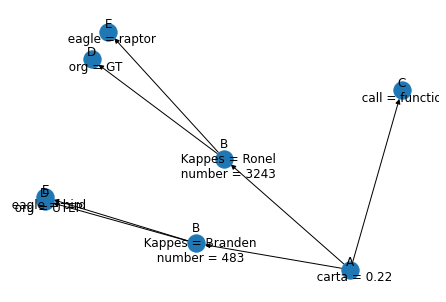

In [14]:
graph = irred._initial_graph
nx.draw_kamada_kawai(graph, labels={n:f"\n  ".join([n.label] + [f"{p.id} = {p.values[0]}" for p in n.properties]) for n in graph.nodes})

In [15]:
pprint(irred.to_json(), indent=2, width=60, sort_dicts=False)

[ { 'id': 'C',
    'type': 'ProcessBuilder',
    'contains': [{'key': 'call', 'value': 'function'}]},
  { 'id': 'B',
    'type': 'WorkflowBuilder',
    'contains': [ {'type': 'D1', 'name': 'D-1'},
                  {'type': 'E', 'name': 'E'}]},
  { 'id': 'E',
    'type': 'ProcessBuilder',
    'contains': [{'key': 'eagle', 'value': 'raptor'}]},
  { 'id': 'E1',
    'type': 'ProcessBuilder',
    'contains': [{'key': 'eagle', 'value': 'bird'}]},
  { 'id': 'B1',
    'type': 'WorkflowBuilder',
    'contains': [ {'type': 'E1', 'name': 'E-1'},
                  {'type': 'D', 'name': 'D'}]},
  { 'id': 'D',
    'type': 'ProcessBuilder',
    'contains': [{'key': 'org', 'value': 'UTEP'}]},
  { 'id': 'D1',
    'type': 'ProcessBuilder',
    'contains': [{'key': 'org', 'value': 'GT'}]},
  { 'id': 'A',
    'type': 'WorkflowBuilder',
    'contains': [ {'type': 'C', 'name': 'C'},
                  {'type': 'B', 'name': 'B'},
                  {'type': 'B1', 'name': 'B-1'}]}]


### Create template entry for each node

### Compose template from original graph and node map